In [31]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider
%matplotlib inline

q0 = 0.4358247775496237 , Leanne solution = 0.27?
xt = 238.76762760253405
19.999999999999993 20.0


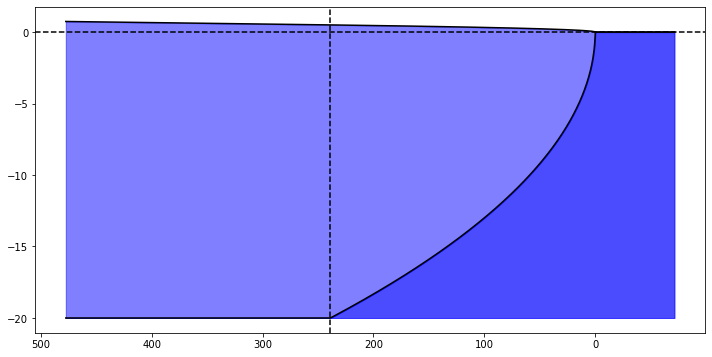

In [30]:
# all units in m and d
K = 20.
Wnet = 20.*1.e-3/365.25  # convert to m/d
z0 = 20.
hb = 3.
xb = 3500.
delta = 0.025

# calculate toe position
def xtf(q0,Wnet,K,z0,delta=0.025):
    return q0/Wnet-np.sqrt((q0/Wnet)**2-(K*delta*(1+delta)*z0**2)/Wnet)

def q0f(K,hb,z0,Wnet,xb,delta=0.025):
    # compute two options for q0
    q0s = ((K*((hb+z0)**2-(1+delta)*z0**2)+Wnet*xb**2)/(2*xb),((1+delta)/delta)*K/(2*xb)*hb**2+Wnet*xb/2)
    # compute two options for wedge toe
    xts = [xtf(q0,Wnet,K,z0) for q0 in q0s]
    # determine which value of q0 to return
    if all([xb>xt for xt in xts]):
        return q0s[0]
    else:
        return q0s[1]

# calculate water table (assumes unconfined->quadratic? same result for confined?)
def hff(x, q0, Wnet, K, z0, xt, delta=0.025):
    try:
        return np.array([hff(xi, q0, Wnet, K, z0, xt, delta=0.025) for xi in x])
    except TypeError:
        if x > xt:
            return np.sqrt((2*q0*x-Wnet*x**2)/K+(1+delta)*z0**2) - z0
        elif x < 0:
            return 0.
        else:
            return np.sqrt((delta/(1+delta))*(2*q0*x-Wnet*x**2)/K)
            
q0 = q0f(K,hb,z0,Wnet,xb)
xt = xtf(q0f(K,hb,z0,Wnet,xb),Wnet,K,z0)
print('q0 =',q0,', Leanne solution = 0.27?')
print('xt =',xt)
print(hff(xt, q0, Wnet, K, z0, xt)/delta, z0)

x = np.linspace(-0.3*xt, 2*xt, 1001)
f,ax = plt.subplots(1,1,figsize=(12,6))
hf = hff(x, q0, Wnet, K, z0, xt)
z = -hf/delta
z = np.array([np.max([-z0, zi]) for zi in z])
ax.fill_between(x, z, hf, color='b', alpha=0.5)
ax.fill_between(x, 0.*z-z0, z, color='b', alpha=0.7)
ax.plot(x,hf,'k-')
ax.plot(x,z,'k-')  # interface
ax.axhline(0, color='k', linestyle='--') # horizontal line at sea level
ax.axvline(xt, color='k', linestyle='--') # vertical line dividing zones 1 and 2
ax.invert_xaxis()


In [51]:
def interface(K, Wnet, hb):

    # set the parameters
    Wnet *= 1.e-3/365.25
    z0 = 20.
    xb = 3500.
    delta = 0.025
    xlim = [-100,500]
    x = np.linspace(*xlim, 1001)
    
    # calculate ground surface as 3 x water table for these numbers
    h0 = 3*hff(x, q0f(20,3,z0,20*1.e-3/365.25,xb), 20*1.e-3/365.25, 20, z0, xtf(q0f(20,3,z0,20*1.e-3/365.25,xb),20*1.e-3/365.25,20,z0))
    
    q0 = q0f(K,hb,z0,Wnet,xb)  # calc outflow
    xt = xtf(q0,Wnet,K,z0)   # calc toe
    hf = hff(x, q0, Wnet, K, z0, xt)   # calc water table

    f,ax = plt.subplots(1,1,figsize=(12,6))
    z = -hf/delta  # calc interface
    z = np.array([np.max([-z0, zi]) for zi in z])  # truncate at aquifer base
    ax.fill_between(x, 0.*z-z0, h0, color='#e1c699', alpha=0.75)  # shade land
    ax.fill_between(x, z, hf, color='b', alpha=0.5)    # shade freshwater
    ax.fill_between(x, 0.*z-z0, z, color='b', alpha=0.7)   # shade saltwater
    ax.plot(x,hf,'k-')  # water table
    ax.plot(x,z,'k-')  # interface
    ax.axhline(0, color='k', linestyle='--') # horizontal line at sea level
    ax.axvline(xt, color='k', linestyle='--') # vertical line dividing zones 1 and 2
    ax.set_xlim(xlim[::-1])    # reverses the x-axis direction
    ax.set_ylim([-z0-0.5, 3.])   # fix ylim to avoid replotting when new parameters
    # add labels for key variables
    ax.text(0.98,0.99,'$q_0$={:3.2f} m$^2$/d'.format(q0), size=12, ha='right', va='top', transform=ax.transAxes)
    ax.text(0.98,0.94,'$x_t$={:d} m'.format(int(xt)), size=12, ha='right', va='top', transform=ax.transAxes)
    plt.show()

# slider objects for varying parameters in argument of interface() function
K = FloatSlider(min=5,max=40,step=5,value=20)
Wnet = FloatSlider(min=5,max=40,step=5,value=20)
hb = FloatSlider(min=0.5,max=10,step=0.5,value=3)

# sets up the interactive widget
interact(interface, K=K, Wnet=Wnet, hb=hb)

interactive(children=(FloatSlider(value=20.0, description='K', max=40.0, min=5.0, step=5.0), FloatSlider(value…

<function __main__.interface(K, Wnet, hb)>